In this notebook, we translate time-varying CO2 saturation in the rocks to the time-varying acoustic properties of the rock, e.g. velocity and density, via patchy saturation model.

Again we load some packages

In [41]:
using JLD2, JUDI, Polynomials, PyPlot, SlimPlotting;

load the model

In [34]:
JLD2.@load "Compass2km.jld2"

5-element Vector{Symbol}:
 :n
 :d
 :o
 :v
 :rho

load the CO2 saturation

In [35]:
JLD2.@load "S.jld2"

2-element Vector{Symbol}:
 :S
 :p

we can again translate the original velocity to permeability and porosity, following the previous notebook

In [36]:
function VtoK(v::Matrix{T}, d::Tuple{T, T}; α=1.03f0) where T

    n = size(v)
    idx_wb = find_water_bottom(v.-minimum(v))
    idx_ucfmt = find_water_bottom((v.-3.5f0).*(v.>3.5f0))
    Kh = zeros(Float32, n)
    capgrid = Int(round(50f0/d[2]))
    for i = 1:n[1]
        Kh[i,1:idx_wb[i]-1] .= 1f-10  # water layer
        Kh[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1] .= α*v[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1].+15f0  # secondary seal
        Kh[i,idx_ucfmt[i]-capgrid:idx_ucfmt[i]-1] .= 1f-3   # seal
        Kh[i,idx_ucfmt[i]:end] .= α*v[i,idx_ucfmt[i]:end].+200f0    # reservoir
    end
    return Kh
end;
function Ktoϕ(K::Matrix{T}, d::Tuple{T, T}) where T

    n = size(K)
    idx_ucfmt = find_water_bottom((K.-1f-3).*((K.==1f-3).|(K.>200f0)))
    capgrid = Int(round(50f0/d[2]))
    phi = zeros(Float32,n)
    for i = 1:n[1]
        for j = 1:n[2]
            p = Polynomial([-0.0314^2*K[i,j],2*0.0314^2*K[i,j],-0.0314^2*K[i,j],1.527^2])
            phi[i,j] = minimum(real(roots(p)[findall(real(roots(p)).== roots(p))]))
        end
        phi[i,idx_ucfmt[i]-capgrid:idx_ucfmt[i]-1] = Float32.(range(0.056,stop=0.1,length=8)) # porosity gradually decreases at the seal
    end
    return phi
end;
K = VtoK(v, d);
ϕ = Ktoϕ(K, d);

we use the `Patchy` function below for conversion

In [37]:
function Patchy(sw::Matrix{T}, vp::Matrix{T}, rho::Matrix{T}, phi::Matrix{T}, d::Tuple{T, T};bulk_fl1 = 2.735f9, bulk_fl2 = 0.125f9,ρw = 7.766f2, ρo = 1.053f3) where T

    n = size(sw)
    capgrid = Int(round(50f0/d[2]))
    vp = vp * 1f3
    vs = vp ./ sqrt(3f0)
    idx_wb = maximum(find_water_bottom(vp.-minimum(vp)))
    idx_ucfmt = find_water_bottom((vp.-3500f0).*(vp.>3500f0))

    bulk_sat1 = rho .* (vp.^2f0 - 4f0/3f0 .* vs.^2f0) * 1f3
    shear_sat1 = rho .* (vs.^2f0) * 1f3

    bulk_min = zeros(Float32,size(bulk_sat1))

    bulk_min[findall(vp.>=3500f0)] .= 5f10   # mineral bulk moduli
    bulk_min[findall(vp.<3500f0)] .= 1.2f0 * bulk_sat1[findall(vp.<3500f0)] # mineral bulk moduli

    patch_temp = bulk_sat1 ./(bulk_min .- bulk_sat1) - bulk_fl1 ./ phi ./ (bulk_min .- bulk_fl1) + bulk_fl2 ./ phi ./ (bulk_min .- bulk_fl2)

    for i = 1:n[1]
        patch_temp[i,idx_ucfmt[i]-capgrid:idx_ucfmt[i]-1] = patch_temp[i,idx_ucfmt[i]:idx_ucfmt[i]+capgrid-1]
    end

    bulk_sat2 = bulk_min./(1f0./patch_temp .+ 1f0)
    bulk_sat2[findall(bulk_sat2-bulk_sat1.>0)] = bulk_sat1[findall(bulk_sat2-bulk_sat1.>0)]

    bulk_new = (bulk_sat1+4f0/3f0*shear_sat1).*(bulk_sat2+4f0/3f0*shear_sat1) ./( (1f0.-sw).*(bulk_sat2+4f0/3f0*shear_sat1) 
    + sw.*(bulk_sat1+4f0/3f0*shear_sat1) ) - 4f0/3f0*shear_sat1

	bulk_new[:,1:idx_wb] = bulk_sat1[:,1:idx_wb]
    bulk_new[findall(sw.==0)] = bulk_sat1[findall(sw.==0)]
    rho_new = rho + phi .* sw * (ρw - ρo) / 1f3
    rho_new[findall(sw.==0)] = rho[findall(sw.==0)]
    Vp_new = sqrt.((bulk_new+4f0/3f0*shear_sat1)./rho_new/1f3)
    Vp_new[findall(sw.==0)] = vp[findall(sw.==0)]

    return Vp_new/1f3, rho_new
end
function Patchy(sw::Array{T, 3}, vp::Matrix{T}, rho::Matrix{T}, phi::Matrix{T}, d::Tuple{T, T};bulk_fl1 = 2.735f9, bulk_fl2 = 0.125f9,ρw = 7.766f2, ρo = 1.053f3) where T

    stack = [Patchy(sw[i,:,:], vp, rho, phi, d; bulk_fl1=bulk_fl1, bulk_fl2=bulk_fl2, ρw = ρw, ρo=ρo) for i = 1:size(sw,1)]
    return [stack[i][1] for i = 1:size(sw,1)], [stack[i][2] for i = 1:size(sw,1)]
end

Patchy (generic function with 2 methods)

we can get the time-varying `v_stack` and `rho_stack` above, containing velocities and densities

In [39]:
v_stack, rho_stack = Patchy(Float32.(S), v, rho, ϕ, d);

Let's check what they look like

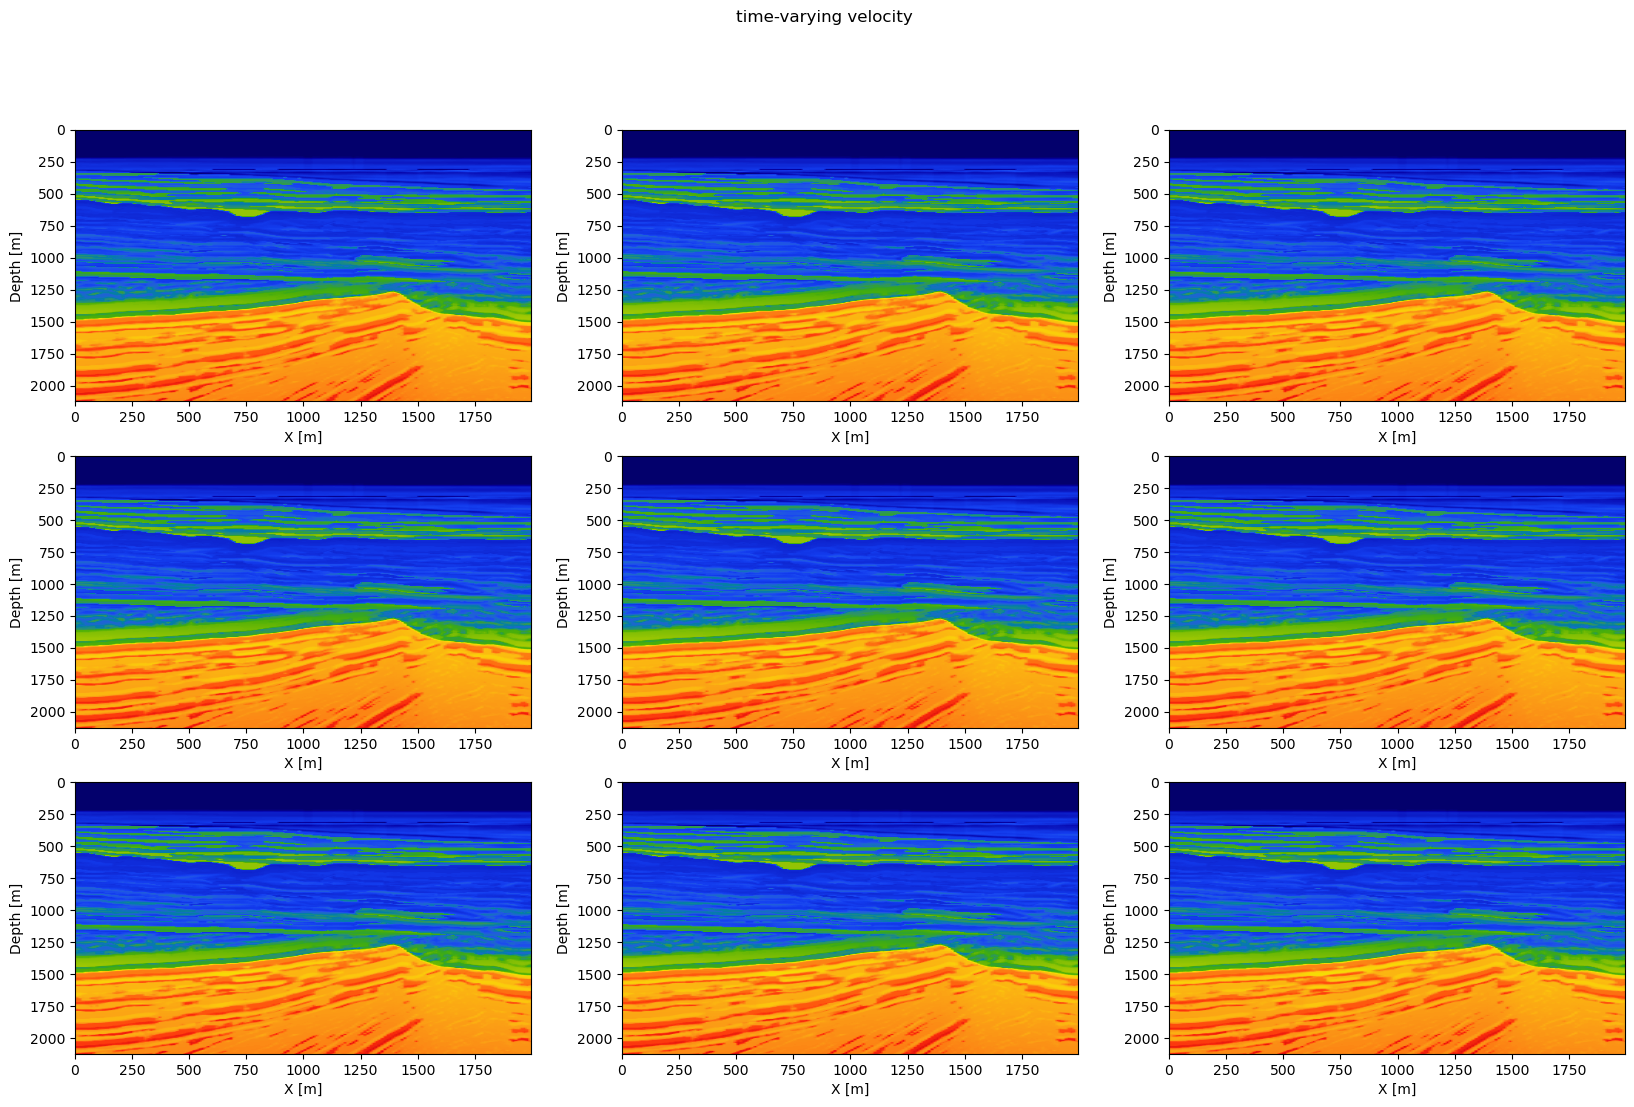

In [44]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=length(v_stack), length=9)));   # 9 observed time samples
for i = 1:9
    subplot(3,3,i)
    plot_velocity(v_stack[obs[i]]', d; name="", new_fig=false);
end
suptitle("time-varying velocity");

It's really hard to see the CO2-induced change of velocity since it is quite subtle! Let's plot the subtractions instead.

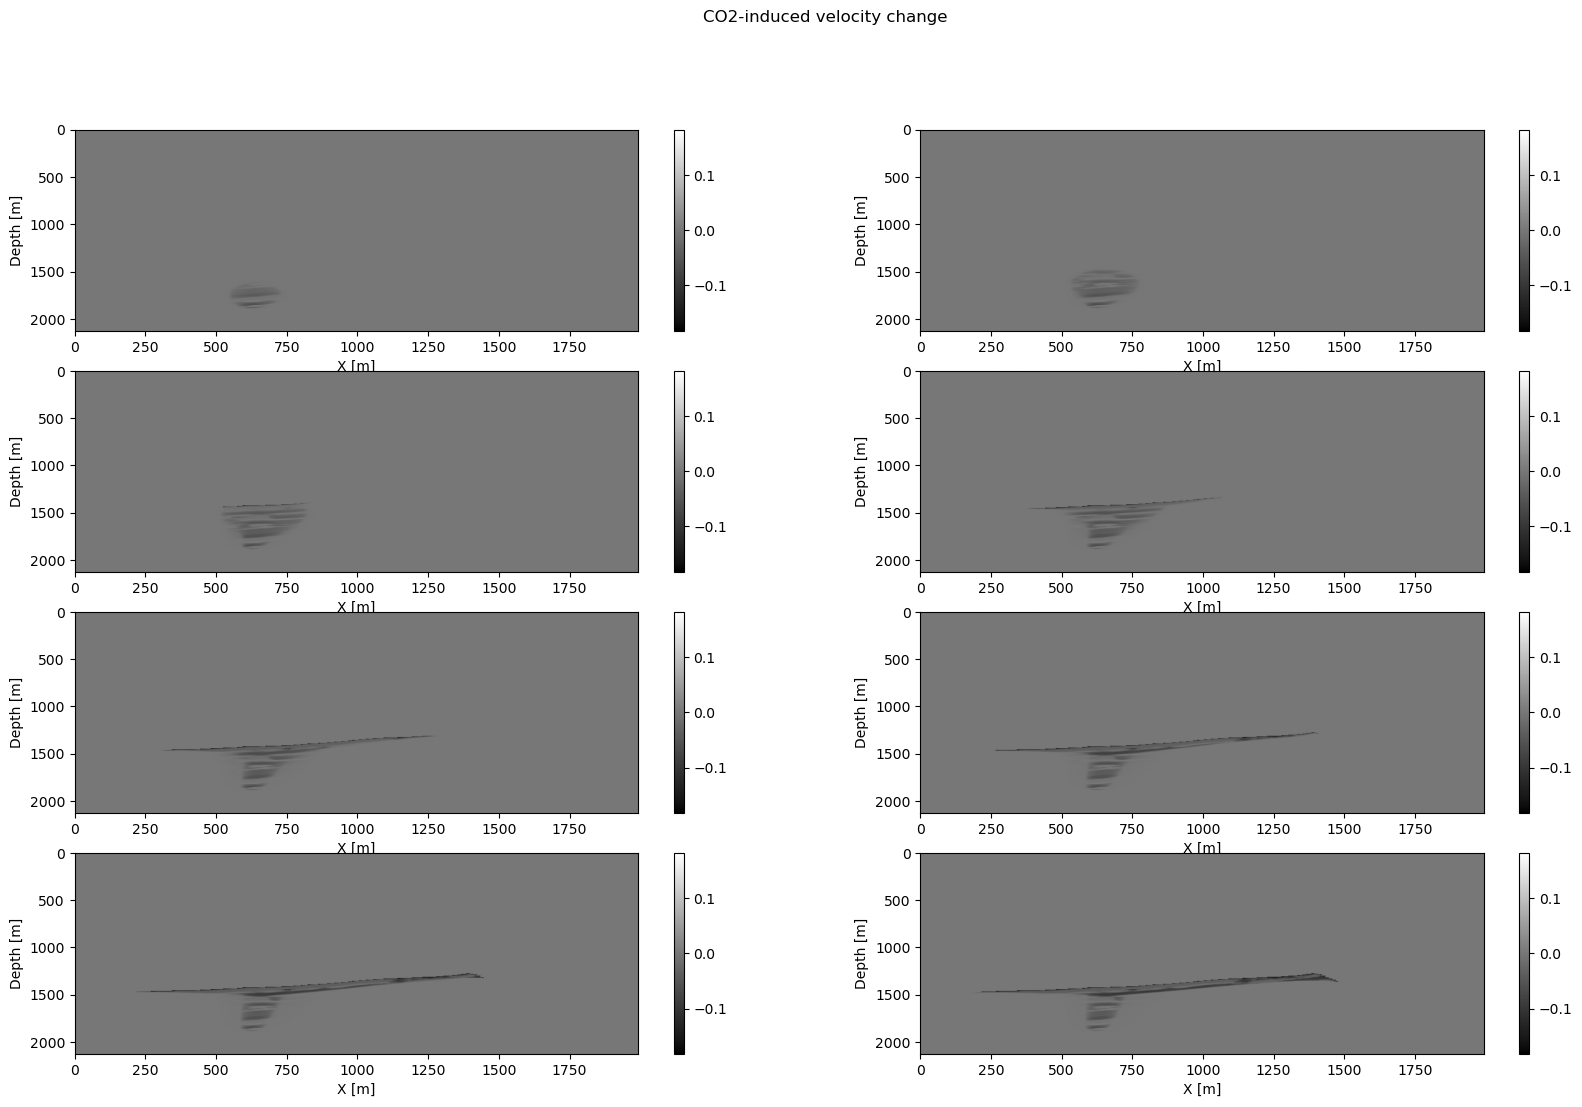

In [53]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=length(v_stack), length=9)));   # 9 observed time samples
for i = 1:8
    subplot(4,2,i)
    plot_simage(v_stack[obs[i+1]]'-v_stack[obs[1]]', d; name="", vmax=maximum(v_stack[1]-v_stack[end]), new_fig=false);
    colorbar();
end
suptitle("CO2-induced velocity change");

Let's then plot the decrease of density

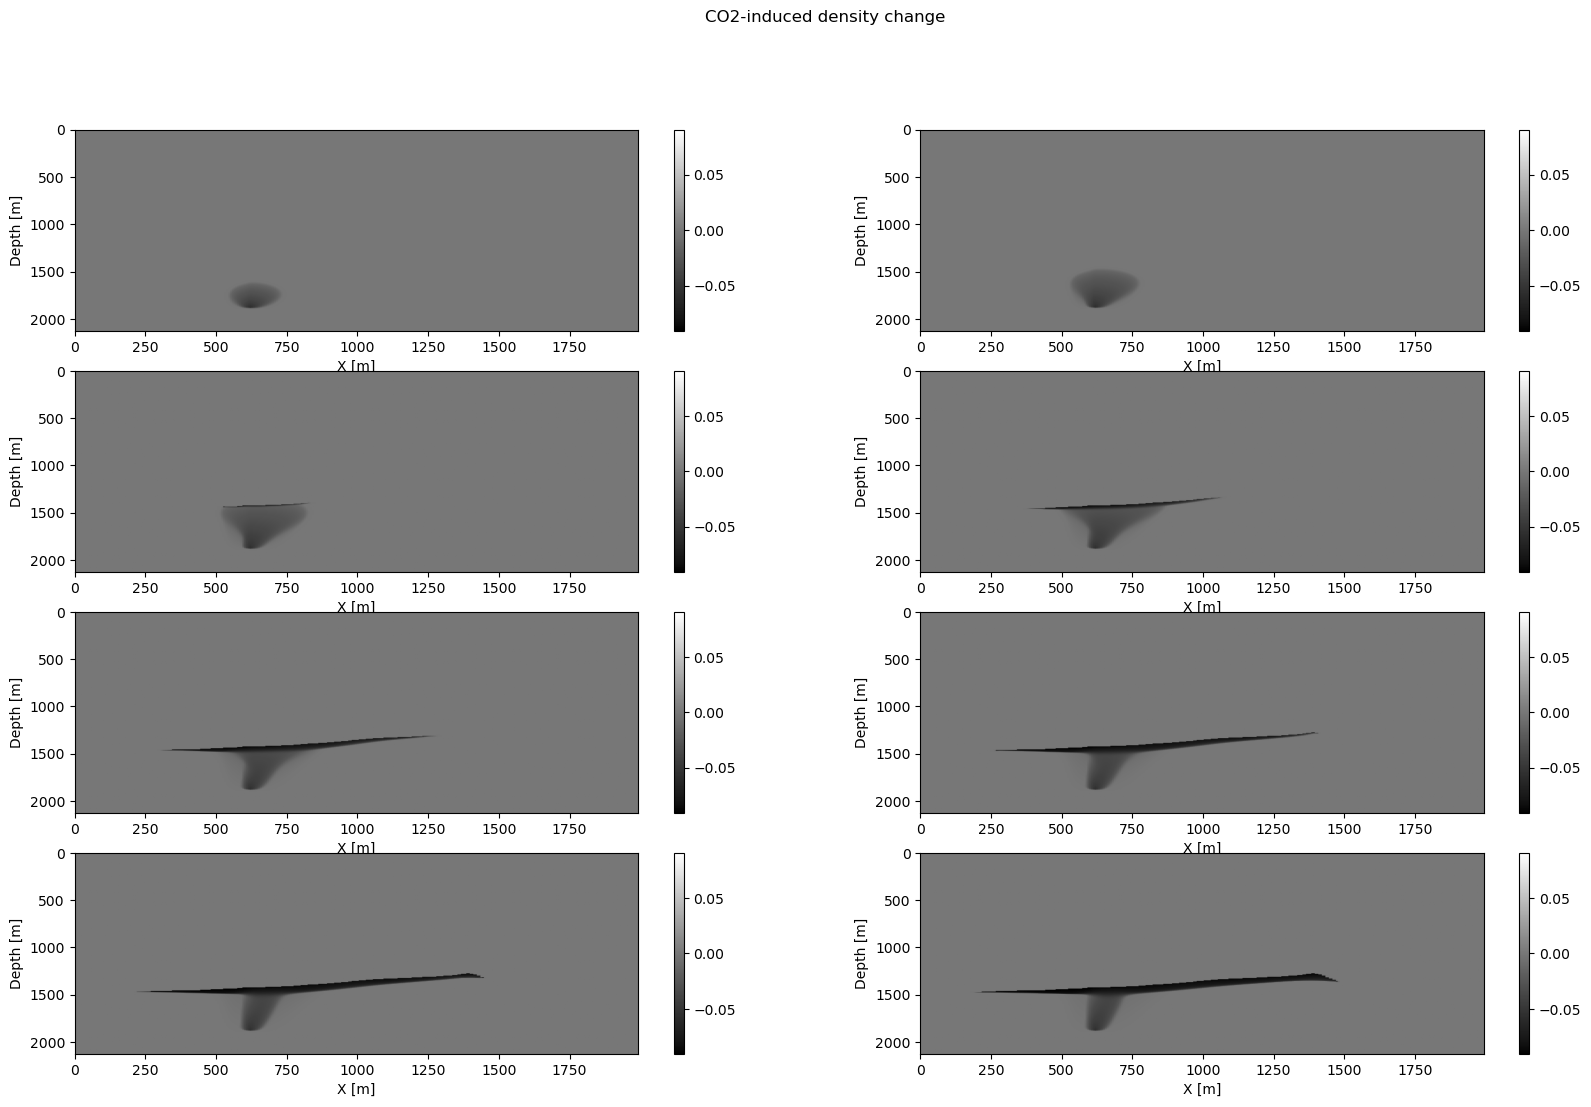

In [54]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=length(rho_stack), length=9)));   # 9 observed time samples
for i = 1:8
    subplot(4,2,i)
    plot_simage(rho_stack[obs[i+1]]'-rho_stack[obs[1]]', d; name="", vmax=maximum(rho_stack[1]-rho_stack[end]), new_fig=false);
    colorbar();
end
suptitle("CO2-induced density change");

As a reference, the CO2 saturation is shown below

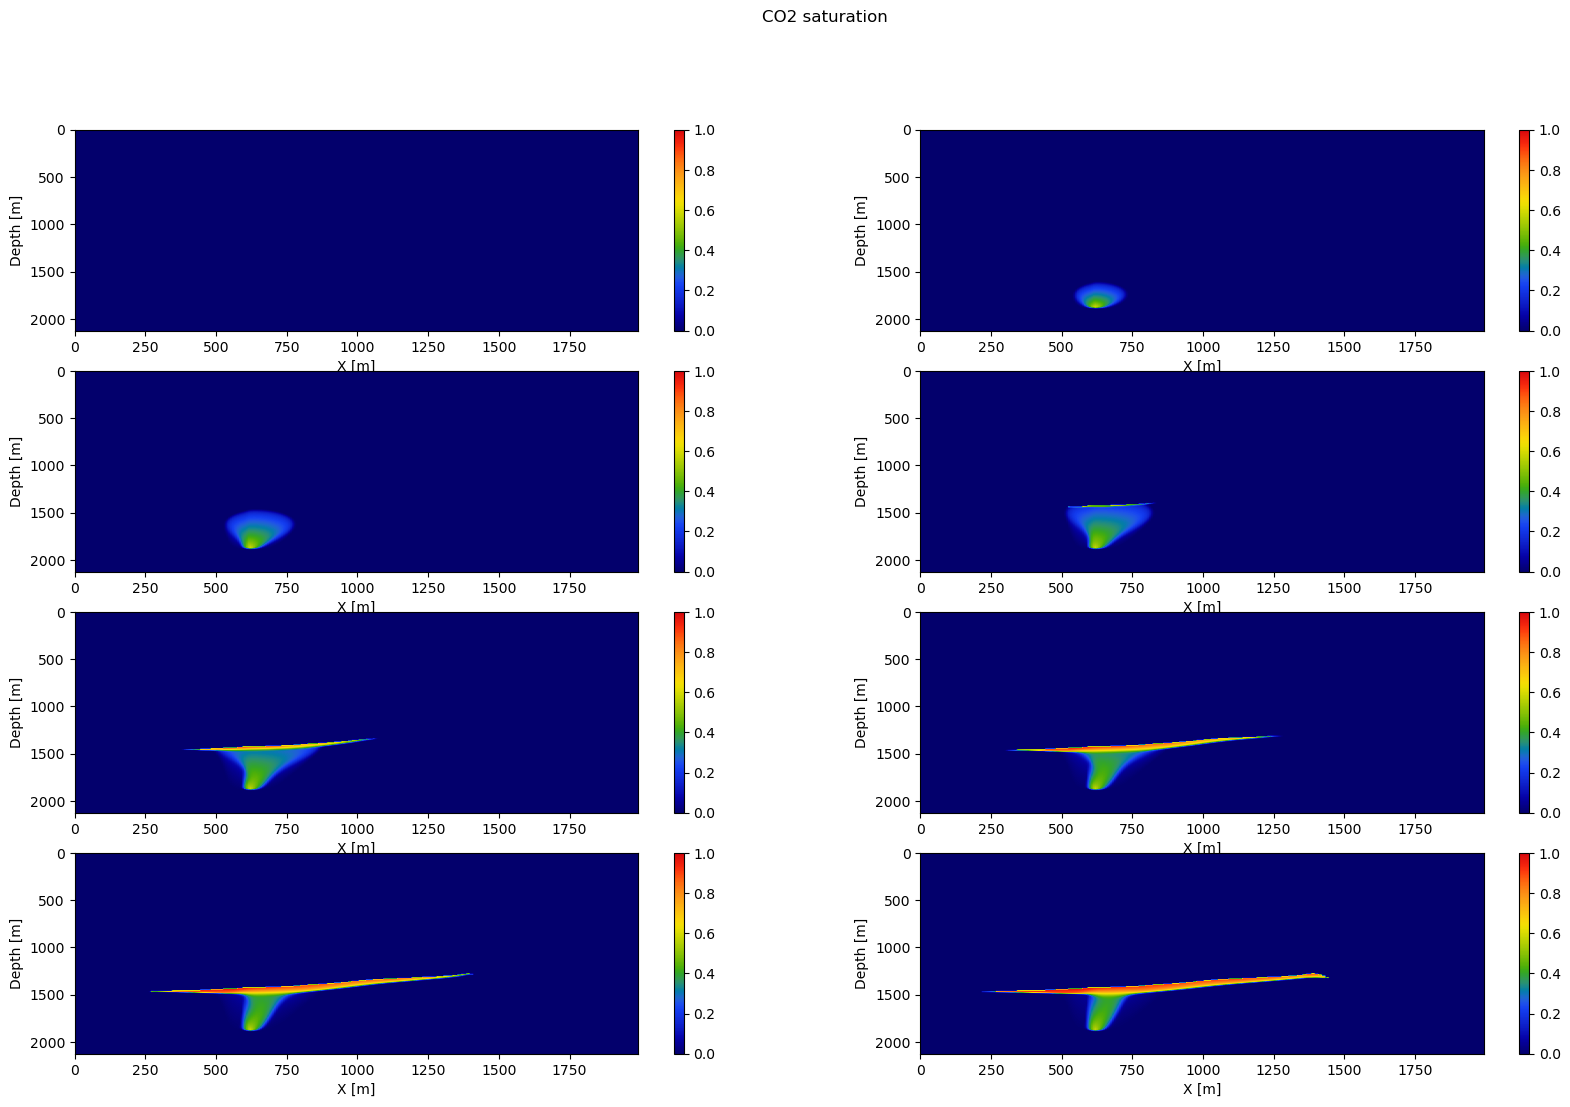

In [57]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=size(S,1), length=9)))[1:8];   # 8 observed time samples
for i = 1:8
    subplot(4,2,i)
    plot_velocity(S[obs[i],:,:]', d; name="", vmax=1, new_fig=false);
    colorbar();
end
suptitle("CO2 saturation");

In [59]:
JLD2.@save "timelapsevrho.jld2" v_stack rho_stack